In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import r2_score
np.random.seed(0)


In [2]:
os.chdir("FirstPart0.8")
os.getcwd()

'/local0/t_wand01/GLE for Finance/FirstPart0.8'

In [3]:

from os import listdir

directory_path = '.'
file_types = ['npy', 'npz']

np_vars = {dir_content: np.load(dir_content)
           for dir_content in listdir(directory_path)
           if dir_content.split('.')[-1] in file_types}

In [4]:
for i in np_vars.keys():
    print(i)

theta_meanEst_B10_K0.npy
MCMCsamples_B10_K3.npy
FirstPart_0.8WeeklyCorr.npy
simulatedDataX_B10_K3_MAP.npy
credibleIntervals_B10_K3.npy
SecondPart_0.8WeeklyCorr.npy
theta_MAPest_B10_K3.npy
theta_direct_SLE_B10.npy
theta_MAPest_B10_K0.npy
n_bin_B10_K0.npy
binsX_B10.npy
credibleIntervals_B10_K0.npy
n_bin_B10_K3.npy
coeff_B10_K0.npy
MCMCsamples_B10_K0.npy
simulatedDataX_B10_K0_MAP.npy
coeff_B10_K3.npy
theta_meanEst_B10_K3.npy
edgesX_B10.npy
MCMCsamples_raw_B10_K0.npy
MCMCsamples_raw_B10_K3.npy


In [5]:
os.chdir("..")
os.getcwd()

'/local0/t_wand01/GLE for Finance'

In [6]:

os.chdir("Predict")
os.getcwd()

'/local0/t_wand01/GLE for Finance/Predict'

## Edges of the Bins for Input Time Series Data

In [7]:
np_vars["edgesX_B10.npy"]

array([0.00523525, 0.0821579 , 0.15908055, 0.2360032 , 0.31292585,
       0.38984849, 0.46677114, 0.54369379, 0.62061644, 0.69753909,
       0.77446173])

## Estimated Parameters

- First ten parameters are for $D^{(1)}$
- Second ten parameters are for $D^{(2)}$
- Last remaining parameters are for Kernel $\mathcal{K}$

In [8]:
print(np.round(np_vars["theta_MAPest_B10_K3.npy"],3))



[ 0.035  0.015 -0.002 -0.001 -0.029 -0.069 -0.045 -0.052 -0.024 -0.007
  0.009  0.01   0.013  0.017  0.017  0.026  0.017  0.028  0.017  0.034
 -0.258 -0.17  -0.172]


In [9]:
# Into a pd.DataFrame

D1D2 = pd.DataFrame({"D1": np_vars["theta_MAPest_B10_K3.npy"][0:10],
                    "D2": np_vars["theta_MAPest_B10_K3.npy"][10:20]})

D1D2_0 = pd.DataFrame({"D1": np_vars["theta_MAPest_B10_K0.npy"][0:10],
                    "D2": np_vars["theta_MAPest_B10_K0.npy"][10:20]})

D1D2.head(), D1D2_0.head()

(         D1        D2
 0  0.035414  0.009295
 1  0.015363  0.009802
 2 -0.001835  0.013474
 3 -0.000777  0.016823
 4 -0.028515  0.017375,
          D1        D2
 0  0.078138  0.011298
 1  0.040081  0.012860
 2  0.004050  0.016971
 3 -0.015335  0.022249
 4 -0.074148  0.020519)

Ensure that Kernel[1] is actually the lag-1-Kernel by adding a zeroth element

In [10]:
Kernel = [0]
Kernel += list(np_vars["theta_MAPest_B10_K3.npy"][20:])
print(np.round(Kernel,3))

[ 0.    -0.258 -0.17  -0.172]


## Prediction

Taken from Eq. (7) in Clemens's Preprint

In [11]:
def getBin(x, Binning):
    # get Bin for observation x via Binning intervals Binning,
    # starts with zeroth Bin
    
    Output = int(sum(x>Binning)) - 1  
    # -1 because lowest interval boundary is minimum
    
    Output = max(0, Output) # if lower than min. in training data
    Output = min(len(Binning)-2, Output) # if higher than max. in training: N interval boundaries-> N-2 intervals
    
    return(int(Output))

    
    
getBin(0.36,np_vars["edgesX_B10.npy"])

4

In [12]:
print(np.round(np_vars["edgesX_B10.npy"],3))

[0.005 0.082 0.159 0.236 0.313 0.39  0.467 0.544 0.621 0.698 0.774]


In [13]:
# This gives me mean and standard deviation of the prediction

def Prediction_mean_std(X_in, d1d2_DF, Kernels, Binning, deltaT, K):
    
    
    assert type(K) == int
    
    Interval = getBin(X_in[-1], Binning)
    
    Output_m = X_in[-1]  # past value
    Output_m +=  d1d2_DF["D1"].loc[Interval] * deltaT # simple Euler ODE
    
    # now for the kernel
    
    for k in range(1,K+1): # sum over 1 to (inclusive) K
        Contribution = 0
        Contribution += Kernel[k] * ( X_in[-1] - X_in[-1-k])*deltaT
        Output_m += Contribution # Kernel effect
    
    # now the stochastic Ito-component
    Output_std = float(np.sqrt(d1d2_DF["D2"].loc[Interval] * deltaT))

        
    return( np.array([Output_m, Output_std]) )

## Test

In [14]:
X = np_vars["FirstPart_0.8WeeklyCorr.npy"]

In [15]:
Prediction_mean_std(X[:-1], D1D2_0, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = 3)

array([0.48596678, 0.1424071 ])

In [16]:
Prediction_mean_std(X, D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = 3)


array([0.67177507, 0.13037534])

In [17]:
m, std = Prediction_mean_std(X, D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = 3)
print(m,std)

0.6717750735007922 0.13037534122621847


# In-Sample Prediction

In [18]:
K_Length = 3

In [19]:
Means = list()
Stds = list()
TrueValues = list()
LastValues = list()
L = len(X)-K_Length-1


for i in range(L):
    TrueValues = TrueValues +  [X[-L+i+1]]
    LastValues = LastValues+  [X[-L+i]]
    mn, st = Prediction_mean_std(X[:-L+i], D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = K_Length)
   
    Means = Means + [mn]
    Stds = Stds + [st]


In [20]:
np.array(Stds).flatten()

array([0.09641311, 0.09900255, 0.11607563, 0.09900255, 0.09641311,
       0.09900255, 0.09641311, 0.09641311, 0.09900255, 0.13181263,
       0.09900255, 0.09641311, 0.09900255, 0.09641311, 0.09900255,
       0.09641311, 0.09900255, 0.09641311, 0.09900255, 0.11607563,
       0.09900255, 0.11607563, 0.09641311, 0.09641311, 0.09900255,
       0.09900255, 0.09641311, 0.09641311, 0.09900255, 0.09641311,
       0.09900255, 0.12970223, 0.09900255, 0.09900255, 0.09900255,
       0.11607563, 0.09641311, 0.09641311, 0.09900255, 0.09641311,
       0.09900255, 0.09641311, 0.09641311, 0.09900255, 0.09900255,
       0.09641311, 0.09641311, 0.09900255, 0.09641311, 0.09641311,
       0.09900255, 0.09900255, 0.12970223, 0.09641311, 0.09900255,
       0.09900255, 0.09900255, 0.09900255, 0.09641311, 0.11607563,
       0.09900255, 0.09641311, 0.09900255, 0.09641311, 0.09641311,
       0.12970223, 0.09900255, 0.09900255, 0.09641311, 0.09641311,
       0.09900255, 0.09900255, 0.09900255, 0.09641311, 0.09641

##### For no Memory

In [21]:
Means_0 = list()
Stds_0 = list()
TrueValues_0 = list()
LastValues_0 = list()
K_Length_0 = 0
L_0 = len(X)-K_Length_0-1


for i in range(L_0):
    TrueValues_0 = TrueValues_0 +  [X[-L_0+i+1]]
    mn, st = Prediction_mean_std(X[:-L_0+i], D1D2_0, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = K_Length_0)
   
    Means_0 = Means_0 + [mn]
    Stds_0 = Stds_0 + [st]


### Some Confidence Interval Checks

In [22]:
LowerCI = np.array(Means)-np.array(Stds) 
UpperCI = np.array(Means)+np.array(Stds) 
ArrayTrueValues = np.array(TrueValues)

LCI_Check = 1.0*(LowerCI<ArrayTrueValues)
UCI_Check =1.0*(UpperCI>ArrayTrueValues)

InCI = LCI_Check * UCI_Check
print(np.mean(InCI))

0.6935866983372921


In [23]:
len(TrueValues)

842

In [24]:
len(X)

846

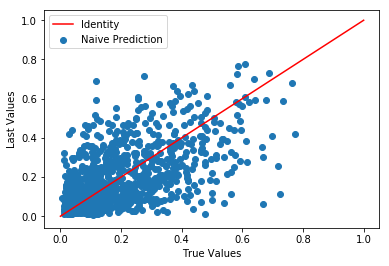

In [25]:
plt.scatter(TrueValues, LastValues, label="Naive Prediction")
plt.xlabel("True Values")
plt.ylabel("Last Values")
plt.plot([0,1],[0,1], label="Identity", c ="r")
plt.legend()
plt.show()

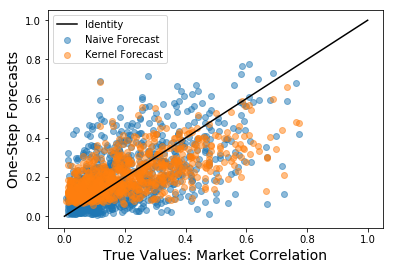

In [26]:
plt.scatter(TrueValues, LastValues, label="Naive Forecast", alpha = 0.5)
#plt.scatter(TrueValues_0, Means_0, label="Langevin without Kernel", alpha = 0.5)
plt.scatter(TrueValues, Means, label="Kernel Forecast", alpha = 0.5)

fs = 14
plt.xlabel("True Values: Market Correlation",fontsize = fs)
plt.ylabel("One-Step Forecasts",fontsize = fs)
plt.plot([0,1],[0,1], label="Identity", c ="k")
plt.legend()
plt.show()

#### Root Mean Square Error and R² Metrics

In [27]:
np.sqrt(np.mean((np.array(TrueValues)-np.array(Means))**2.))

0.12174555608592091

In [28]:
np.sqrt(np.mean((np.array(TrueValues)-np.array(LastValues))**2.))

0.14987040176284736

R^2 of GLE

In [29]:
r2_score(y_true=TrueValues, y_pred=Means)

0.3891926742685482

R² of LE

In [30]:
r2_score(y_true=TrueValues_0, y_pred=Means_0) #0.3487483090652824

0.2880065610692544

R² of Naive

In [31]:
r2_score(y_true=TrueValues, y_pred=LastValues)

0.07438636220207773

# Out-Of-Sample Prediction

In [32]:
test_data = np_vars["SecondPart_0.8WeeklyCorr.npy"]
len(test_data)

211

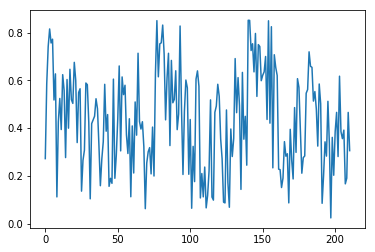

In [33]:
plt.plot(test_data)
plt.show()

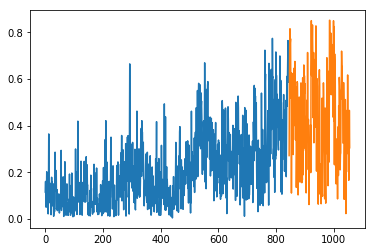

In [34]:
X_full = np.concatenate([X,test_data])
plt.plot(X)
plt.plot(np.arange( len(X), len(X)+len(test_data)),
        test_data)
plt.show()

In [35]:
len(test_data)

211

In [36]:
Means_test = list()
Stds_test = list()
TrueValues_test = list()
LastValues_test = list()
L = len(test_data)+1  # +1 because first TrueValues is [X[-L+i+1]]


for i in range(L):
    TrueValues_test = TrueValues_test +  [X_full[-L+i+1]]
    LastValues_test = LastValues_test+  [X_full[-L+i]]
    mn, st = Prediction_mean_std(X_full[:-L+i], D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = K_Length)
   
    Means_test = Means_test + [mn]
    Stds_test = Stds_test + [st]


In [37]:
len(X_full)

1057

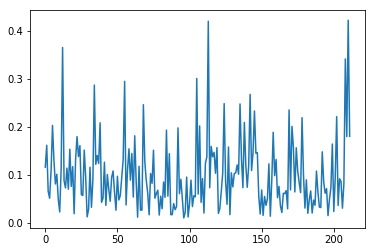

In [38]:
plt.plot(X_full[:-L_0])

##### For no Memory

In [39]:
Means_0_test = list()
Stds_0_test = list()
TrueValues_0_test = list()
LastValues_0_test = list()
K_Length_0 = 0
L_0 = len(test_data)+1  # +1 because first TrueValues is [X[-L+i+1]]

print(L_0-1)
for i in range(L_0):

    mn, st = Prediction_mean_std(X_full[:-L_0+i], D1D2_0, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = K_Length_0)
   
    TrueValues_0_test = TrueValues_0_test +  [X_full[-L+i+1]]
    Means_0_test = Means_0_test + [mn]
    Stds_0_test = Stds_0_test + [st]


211


In [40]:
len(TrueValues_0_test), len(Means_0_test), len(TrueValues_test)

(212, 212, 212)

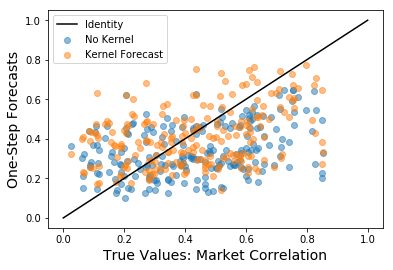

In [41]:
#plt.scatter(TrueValues_test, LastValues_test, label="Naive Forecast", alpha = 0.5)
plt.scatter(TrueValues_0_test, Means_0_test, label="No Kernel", alpha = 0.5)

plt.scatter(TrueValues_test, Means_test, label="Kernel Forecast", alpha = 0.5)

fs = 14
plt.xlabel("True Values: Market Correlation",fontsize = fs)
plt.ylabel("One-Step Forecasts",fontsize = fs)
plt.plot([0,1],[0,1], label="Identity", c ="k")
plt.legend()
plt.show()

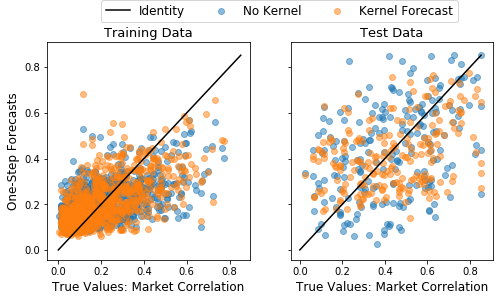

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (8,4),sharey=True)


Maximum = max(max(TrueValues), max(TrueValues_0), max(Means_0), max(Means),
              max(TrueValues_test), max(TrueValues_0_test), max(Means_0_test),max(Means_test))


ax[0].scatter(TrueValues_0, Means_0, label="No Kernel", alpha = 0.5)
ax[0].scatter(TrueValues, Means, label="Kernel Forecast", alpha = 0.5)

fs = 12
ax[0].set_xlabel("True Values: Market Correlation",fontsize = fs)
ax[0].set_ylabel("One-Step Forecasts",fontsize = fs)
ax[0].plot([0,Maximum],[0,Maximum], label="Identity", c ="k")
ax[0].set_title("Training Data", fontsize = fs+1)
#ax[0].legend()


ax[1].scatter(TrueValues_0_test, LastValues_test, label="No Kernel", alpha = 0.5)
ax[1].scatter(TrueValues_test, Means_test, label="Kernel Forecast", alpha = 0.5)
ax[1].set_xlabel("True Values: Market Correlation",fontsize = fs)
ax[1].plot([0,Maximum],[0,Maximum], label="Identity", c ="k")
ax[1].set_title("Test Data", fontsize = fs+1)


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.2,0.925),ncol=3, fontsize = fs)

plt.savefig("Prediction_Evaluation.pdf", bbox_inches="tight", dpi = 500)

plt.show()

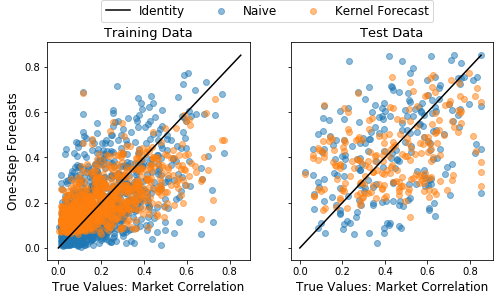

In [43]:
fig, ax = plt.subplots(1, 2, figsize = (8,4),sharey=True)


Maximum = max(max(TrueValues), max(TrueValues_0), max(Means_0), max(Means),
              max(TrueValues_test), max(TrueValues_0_test), max(LastValues_test))


ax[0].scatter(TrueValues, LastValues, label="Naive", alpha = 0.5)
ax[0].scatter(TrueValues, Means, label="Kernel Forecast", alpha = 0.5)

fs = 12
ax[0].set_xlabel("True Values: Market Correlation",fontsize = fs)
ax[0].set_ylabel("One-Step Forecasts",fontsize = fs)
ax[0].plot([0,Maximum],[0,Maximum], label="Identity", c ="k")
ax[0].set_title("Training Data", fontsize = fs+1)
#ax[0].legend()


ax[1].scatter(TrueValues_test, LastValues_test, label="Naive", alpha = 0.5)
ax[1].scatter(TrueValues_test, Means_test, label="Kernel Forecast", alpha = 0.5)
ax[1].set_xlabel("True Values: Market Correlation",fontsize = fs)
ax[1].plot([0,Maximum],[0,Maximum], label="Identity", c ="k")
ax[1].set_title("Test Data", fontsize = fs+1)


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.2,0.925),ncol=3, fontsize = fs)

plt.savefig("Prediction_Evaluation_Naive.pdf", bbox_inches="tight", dpi = 500)

plt.show()

#### Root Mean Square Error and R² 

In [44]:
np.sqrt(np.mean((np.array(TrueValues_test)-np.array(Means_test))**2.))

0.20451573376225035

In [45]:
np.sqrt(np.mean((np.array(TrueValues_0_test)-np.array(Means_0_test))**2.))

0.2192227021530017

In [46]:
np.sqrt(np.mean((np.array(TrueValues_test)-np.array(LastValues_test))**2.))

0.22593350634550657

R² of GLE:

In [47]:
r2_score(y_true=TrueValues_test, y_pred=Means_test)

0.004608659689078531

R² of LE:

In [48]:
r2_score(y_true=TrueValues_0_test, y_pred=Means_0_test) # 0.07228434075280932

-0.14369826417838039

R^2 of Naive:

In [49]:
r2_score(y_true=TrueValues_test, y_pred=LastValues_test)

-0.21479135743005018

In [50]:
Means_test[-1], TrueValues_test[-1]

(0.26252758541563437, 0.11584862290253742)

### Again, CIs

In [51]:
LowerCI_test = np.array(Means_test)-np.array(Stds_test) 
UpperCI_test = np.array(Means_test)+np.array(Stds_test) 
ArrayTrueValues_test = np.array(TrueValues_test)

LCI_Check_test = 1.0*(LowerCI_test<ArrayTrueValues_test)
UCI_Check_test =1.0*(UpperCI_test>ArrayTrueValues_test)

InCI_test = LCI_Check_test * UCI_Check_test
print(np.mean(InCI_test))

0.5188679245283019
